<a href="https://colab.research.google.com/github/sli032/BIO-PHY4100/blob/main/Viral_Capsid_Modeling_PyMembrane.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Viral Capsid Modeling with PyMembrane
This notebook demonstrates how to model a T=3 icosahedral viral capsid and compute its elastic energy using the [PyMembrane](https://github.com/fdmatoz/PyMembrane) package.

## Package Installation

In [ ]:
%%capture
# Install and setup (run only once)
!git clone https://github.com/fdmatoz/PyMembrane.git
%cd /content/PyMembrane/pymembrane/cppmodule/external
!rm -rf pybind11
!git clone https://github.com/pybind/pybind11.git pybind11
%cd /content/PyMembrane/
!python setup.py install

## Load T=3 Icosahedral Capsid Mesh

In [ ]:
%cd /content/
import pymembrane as pm
import numpy as np

/content


ModuleNotFoundError: No module named 'pymembrane'

In [13]:
%%capture
!wget https://raw.githubusercontent.com/sli032/BIO-PHY4100/main/faces_T1.inp -O faces_T1.inp
!wget https://raw.githubusercontent.com/sli032/BIO-PHY4100/main/vertices_T1.inp -O vertices_T1.inp

In [14]:
!ls

faces_T1.inp  sample_data  vertices_T1.inp


In [ ]:
box = pm.Box(40.0, 40.0, 40.0)
system = pm.System(box)

# Load the vertex and face files (ensure these are in the working directory)
vertex_file = 'vertices.inp'
face_file = 'faces.inp'
system.read_mesh_from_files(files={'vertices':vertex_file, 'faces':face_file})

dump = system.dumper
dump.vtk("initial mesh", False)

evolver = pm.Evolver(system)

Mesh
 Numvertices  12
 NumFaces  20
 NumEdges  30
 NumHEdges  60


## Define Elastic Properties and Compute Energy

In [ ]:
evolver.add_force("Mesh>Harmonic", {"k": {"0": str(10.0)},
                                    "l0": {"0": str(1.0)}})

evolver.add_force("Mesh>Bending>Dihedral", {"kappa":{"0": str(10.0)}})
evolver.add_force("Mesh>Limit", {"lmin": {"0": str(0.7)},
                                 "lmax": {"0": str(1.3)}})

evolver.add_integrator("Mesh>MonteCarlo>vertex>move", {"dr":"0.008", "spherical_move": "false"})
evolver.add_integrator("Mesh>MonteCarlo>edge>swap", {"every step": str(100)})

In [ ]:
compute = system.compute
edge_lengths = compute.edge_lengths()
print(edge_lengths)

[1.0000000000000002, 1.0000000000000007, 1.0000000000000007, 0.9999999999999993, 0.9999999999999998, 1.0000000000000002, 0.9999999999999997, 0.9999999999999998, 0.9999999999999998, 0.9999999999999999, 1.0000000000000002, 0.9999999999999996, 1.0000000000000004, 0.9999999999999993, 1.0, 1.0000000000000002, 1.0, 1.0000000000000002, 1.0000000000000004, 1.0000000000000004, 0.9999999999999998, 1.0, 1.0000000000000004, 1.0, 0.9999999999999998, 1.0, 1.0000000000000002, 0.9999999999999997, 1.0000000000000004, 0.9999999999999998]


In [ ]:
snapshots = 10
run_steps = 10000
## Compute the initial energy
mc_energy = snapshots*[None]
mc_energy[0] = compute.energy(evolver)['edges']/system.Numedges
print("[Initial] energy = {}".format(mc_energy[0]))
dump.vtk("sphere_t0")
for snapshot in range(1, snapshots):
    for ti, temperature in enumerate([10^-3,10^-5,10^-7,0]): #using heating and cooling cycles
        evolver.set_global_temperature(str(temperature))
        evolver.evolveMC(steps=run_steps)
        dump.vtk("sphere_t" + str(snapshot*run_steps))
        mc_energy[snapshot] =  compute.energy(evolver)['edges']/system.Numedges
        print("[{}] energy = {}".format(snapshot,  mc_energy[snapshot]))

dump.vtk('final_mesh')

[Initial] energy = 2.546440075000699
[1] energy = 2.9345087724198033
[1] energy = 3.292577177480953
[1] energy = 3.614939323334214
[1] energy = 2.5464405351235446
[2] energy = 3.040072150280392
[2] energy = 3.024854185766078
[2] energy = 3.583729483794802
[2] energy = 2.546440573778573
[3] energy = 3.078695094481598
[3] energy = 3.1688631393491877
[3] energy = 2.8638051353280947
[3] energy = 2.5464405933537946
[4] energy = 3.8274912110617842
[4] energy = 3.328306511370867
[4] energy = 3.2959667226377274
[4] energy = 2.5464407719157807
[5] energy = 2.8981929524634253
[5] energy = 4.048295840964829
[5] energy = 3.0691735623830243
[5] energy = 2.54644056070529
[6] energy = 3.374054149003848
[6] energy = 3.469583440164996
[6] energy = 4.199014335317726
[6] energy = 2.5464409244977957
[7] energy = 3.012076694847315
[7] energy = 3.1037032583515143
[7] energy = 3.0229753125155763
[7] energy = 2.5464403208509143
[8] energy = 3.1181434133374517
[8] energy = 3.094814779371889
[8] energy = 3.2428

In [ ]:
# from google.colab import files
# files.download('minimization_t0.vtp')
# files.download('minimization_t0_edges.vtp')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Visualization
To visualize the capsid structure, export the mesh and use a tool like [ParaView](https://www.paraview.org/).

In [ ]:
!pip install pyvista
!pip install matplotlib

In [ ]:
!ls

 faces.inp		   sphere_t10000.vtp	     sphere_t60000.vtp
 final_mesh_edges.vtp	   sphere_t20000_edges.vtp   sphere_t70000_edges.vtp
 final_mesh.vtp		   sphere_t20000.vtp	     sphere_t70000.vtp
'initial mesh_edges.vtp'   sphere_t30000_edges.vtp   sphere_t80000_edges.vtp
'initial mesh.vtp'	   sphere_t30000.vtp	     sphere_t80000.vtp
 PyMembrane		   sphere_t40000_edges.vtp   sphere_t90000_edges.vtp
 sample_data		   sphere_t40000.vtp	     sphere_t90000.vtp
 sphere_t0_edges.vtp	   sphere_t50000_edges.vtp   vertices.inp
 sphere_t0.vtp		   sphere_t50000.vtp
 sphere_t10000_edges.vtp   sphere_t60000_edges.vtp


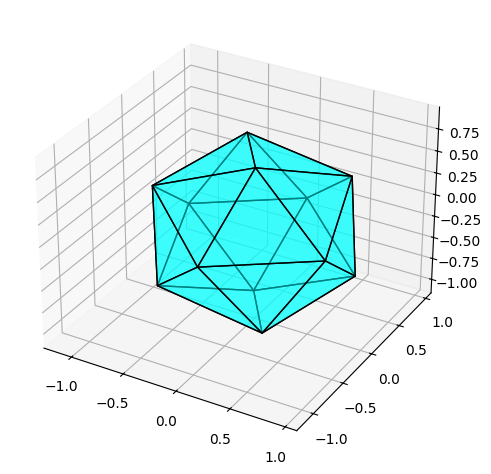

In [ ]:
import pyvista as pv
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

# mesh = pv.Sphere()
mesh = pv.read('sphere_t90000.vtp')

points = mesh.points
faces = mesh.faces.reshape((-1, 4))[:, 1:]

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

poly3d = [points[face] for face in faces]
collection = Poly3DCollection(poly3d, facecolor='cyan', edgecolor='k', alpha=0.5)
ax.add_collection3d(collection)

scale = points.flatten()
ax.auto_scale_xyz(scale, scale, scale)

plt.tight_layout()
plt.show()

In [ ]:
# mesh = examples.download_bunny_coarse()
# cpos = [(0.2, 0.3, 0.9), (0, 0, 0), (0, 1, 0)]
# mesh.plot(cpos=cpos, show_edges=True, color=True, interactive=False)

## Comparison with Arbitrary Geometry
Repeat the same steps above using a different mesh file (with the same number of triangular subunits) and compare the resulting elastic energy.